<h2>About this Project</h2>
<p>In this project, you will implement a Classification and Regression Tree (CART) algorithm. You will work with the <a href="https://archive.ics.uci.edu/ml/datasets/Ionosphere">Ionosphere Data Set from the UCI Machine Learning Repository</a>, which consists of radar data from a system designed to target free electrons in the ionosphere. The data will be used to determine if a radar return was "good" (i.e. a signal was returned) or "bad" (i.e. the signal passed straight through the ionosphere). Your task will be to classify whether a return is good or bad based on the data.</p>

<h3>Evaluation</h3>

<p><strong>This project must be successfully completed and submitted in order to receive credit for this course. Your score on this project will be included in your final grade calculation.</strong><p>
    
<p>You are expected to write code where you see <em># YOUR CODE HERE</em> within the cells of this notebook. Not all cells will be graded; code input cells followed by cells marked with <em>#Autograder test cell</em> will be graded. Upon submitting your work, the code you write at these designated positions will be assessed using an "autograder" that will run all test cells to assess your code. You will receive feedback from the autograder that will identify any errors in your code. Use this feedback to improve your code if you need to resubmit. Be sure not to change the names of any provided functions, classes, or variables within the existing code cells, as this will interfere with the autograder. Also, remember to execute all code cells sequentially, not just those you’ve edited, to ensure your code runs properly.</p>
    
<p>You can resubmit your work as many times as necessary before the submission deadline. If you experience difficulty or have questions about this exercise, use the Q&A discussion board to engage with your peers or seek assistance from the instructor.<p>

<p>Before starting your work, please review <a href="https://s3.amazonaws.com/ecornell/global/eCornellPlagiarismPolicy.pdf">eCornell's policy regarding plagiarism</a> (the presentation of someone else's work as your own without source credit).</p>

<h3>Submit Code for Autograder Feedback</h3>

<p>Once you have completed your work on this notebook, you will submit your code for autograder review. Follow these steps:</p>

<ol>
  <li><strong>Save your notebook.</strong></li>
  <li><strong>Mark as Completed —</strong> In the blue menu bar along the top of this code exercise window, you’ll see a menu item called <strong>Education</strong>. In the <strong>Education</strong> menu, click <strong>Mark as Completed</strong> to submit your code for autograder/instructor review. This process will take a moment and a progress bar will show you the status of your submission.</li>
	<li><strong>Review your results —</strong> Once your work is marked as complete, the results of the autograder will automatically be presented in a new tab within the code exercise window. You can click on the assessment name in this feedback window to see more details regarding specific feedback/errors in your code submission.</li>
  <li><strong>Repeat, if necessary —</strong> The Jupyter notebook will always remain accessible in the first tabbed window of the exercise. To reattempt the work, you will first need to click <strong>Mark as Uncompleted</strong> in the <strong>Education</strong> menu and then proceed to make edits to the notebook. Once you are ready to resubmit, follow steps one through three. You can repeat this procedure as many times as necessary.</li>
</ol>

<h2>Implementing CART</h2>

### Getting Started

Before you get started, let's import a few packages that you will need. You will also load a data set <a href="https://archive.ics.uci.edu/ml/datasets/Ionosphere">ION</a>, which you will use for our binary test classification problem.

In [1]:
import numpy as np
from pylab import *
from numpy.matlib import repmat
import matplotlib 
import matplotlib.pyplot as plt
from scipy.io import loadmat
import time
import sys

%matplotlib notebook

sys.path.append('/home/codio/workspace/.guides/hf')
from helper import *

print('You\'re running python %s' % sys.version.split(' ')[0])

You're running python 3.7.3


In [2]:
# load in some binary test data (labels are -1, +1)
data = loadmat("ion.mat")

# Load the training data
xTrIon  = data['xTr'].T
yTrIon  = data['yTr'].flatten()

# Load the test data
xTeIon  = data['xTe'].T
yTeIon  = data['yTe'].flatten()

## Tree Structure

<p>We've provided a tree structure for you with distinct leaves and nodes. Leaves have two fields, parent (another node) and prediction (a numerical value).</p>

### Nodes have six fields:

<ol>
<li> <b>left</b>: node describing left subtree </li>
<li> <b>right</b>: node describing right subtree </li>
<li> <b>parent</b>: the parent of the current subtree. The head of the tree always has <code><b>None</b></code> as its parent. Feel free to initialize nodes with this field set to <code><b>None</b></code> as long as you set the correct parent later on. </li>
<li> <b>cutoff_id</b>: index of feature to cut </li>
<li> <b>cutoff_val</b>: cutoff value c (<=c : left, and >c : right)</li>
<li> <b>prediction</b>: prediction at this node </li>
</ol>

In [3]:
class TreeNode(object):
    """Tree class.
    (You don't need to add any methods or fields here but feel
    free to if you like. The tests will only reference the fields
    defined in the constructor below, so be sure to set these
    correctly.)
    """
    
    def __init__(self, left, right, parent, cutoff_id, cutoff_val, prediction):
        self.left = left
        self.right = right
        self.parent = parent
        self.cutoff_id = cutoff_id
        self.cutoff_val = cutoff_val
        self.prediction = prediction

The code below generates spiral data using the trigonometric functions sine and cosine, then splits the data into train and test segments.

In [4]:
def spiraldata(N=300):
    r = np.linspace(1,2*np.pi,N) # generate a vector of "radius" values
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T # generate a curve that draws circles with increasing radius
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    # Now sample alternating values to generate the test and train sets.
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    return xTr, yTr, xTe, yTe

xTrSpiral, yTrSpiral, xTeSpiral, yTeSpiral = spiraldata(150)

We can plot xTrSpiral to see the curve generated by the function above:

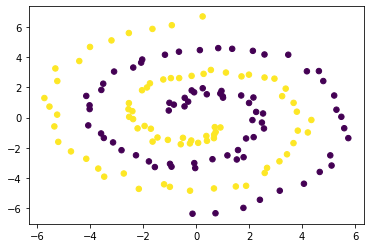

In [7]:
plt.scatter(xTrSpiral[:,0], xTrSpiral[:,1],30,yTrSpiral)

<h2> Implement Regression Trees </h2>


<h3> Part One [Graded]</h3>

<p>First, implement the function <code>sqlmpurity</code> which takes as input a vector of $n$ labels and outputs the corresponding squared loss impurity
    $$\sum_{i} (y_i-\bar{y}_i)^2 \textrm{ where: } \bar{y}_i=\frac{1}{n}\sum_{i} y_i$$
</p>

In [29]:
def sqimpurity(yTr):
    """Computers the weighted variance of the labels
    
    Input:
        yTr:     n-dimensional vector of labels
    
    Output:
        impurity: weighted variance / squared loss impurity of this data set
"""
    
    N, = yTr.shape
    assert N > 0 # must have at least one sample
    impurity=np.inf
    ### BEGIN SOLUTION
    impurity=np.var(yTr)*N
    ### END SOLUTION
    return impurity

INSERT TESTS here

Now implement <code>sqsplit</code>, which takes as input a data set with labels and computes the best feature and cut-value of an optimal split based on the squared error impurity. The <code>sqsplit</code> function takes as input a data set of row vectors and a label vector and outputs a feature dimension, a cut threshold, and the impurity loss of this best split. To find the best split, evaluate all possible splits and then search for the split that yields the minimum loss. 

In [ ]:
def sqsplit(xTr,yTr):
    """Finds the best feature, cut value, and loss value.
    
    Input:
        xTr:     n x d matrix of data points
        yTr:     n-dimensional vector of labels
    
    Output:
        feature:  index of the best cut's feature
        cut:      cut-value of the best cut
        bestloss: loss of the best cut
    """
    N,D = xTr.shape
    assert D > 0 # must have at least one dimension
    assert N > 1 # must have at least two samples
    bestloss = np.inf
    feature = np.inf
    cut = np.inf

    
        
    assert feature != np.inf and cut != np.inf
    ### END SOLUTION
    
    return feature, cut, bestloss

In [8]:
def sqsplit(xTr,yTr,weights=None):
    """Finds the best feature, cut value, and loss value.
    
    Input:
        xTr:     n x d matrix of data points
        yTr:     n-dimensional vector of labels
        weights: n-dimensional weight vector for data points
    
    Output:
        feature:  index of the best cut's feature
        cut:      cut-value of the best cut
        bestloss: loss of the best cut
    """
    N,D = xTr.shape
    assert D > 0 # must have at least one dimension
    assert N > 1 # must have at least two samples
    if weights is None: # if no weights are passed on, assign uniform weights
        weights = np.ones(N)
    weights = weights/sum(weights) # Weights need to sum to one (we just normalize them)
    bestloss = np.inf
    feature = np.inf
    cut = np.inf
    
    ### BEGIN SOLUTION
    for d in range(D):
        ii = xTr[:, d].argsort() # sort data along that dimensions
        xs = xTr[ii, d] # sorted feature values
        ws = weights[ii] # sorted weights
        ys = yTr[ii] # sorted labels
        
        # Get indices where we should split
        idif = np.where(np.logical_not(np.isclose(np.diff(xs, axis=0), 0)))[0]
        
        for j in idif:
            T_L = (ws[:j + 1] @ ys[:j + 1]) / np.sum(ws[:j + 1])
            T_R = (ws[j + 1: ] @ ys[j + 1:]) / np.sum(ws[j + 1:])
            
            left_loss = ((ys[:j + 1] - T_L)**2) @ ws[:j + 1]
            right_loss = ((ys[j + 1:] - T_R)**2) @ ws[j + 1:]
            
            loss = left_loss + right_loss            
            if loss < bestloss:
                feature = d
                cut = (xs[j]+xs[j+1])/2
                bestloss = loss
        
    assert feature != np.inf and cut != np.inf
    ### END SOLUTION
    
    return feature, cut, bestloss

In [ ]:
# The tests below check that your sqsplit function returns the correct values for several different input datasets

t0 = time.time()
fid, cut, loss = sqsplit(xTrIon,yTrIon)
t1 = time.time()

print('Elapsed time: {:0.2f} seconds'.format(t1-t0))
print("The best split is on feature 2 on value 0.304")
print("Your tree split on feature %i on value: %2.3f \n" % (fid,cut))

def sqsplit_test1():
    a = np.isclose(sqsplit(xor4,yor4)[2], .25)
    b = np.isclose(sqsplit(xor3,yor3)[2], .25)
    c = np.isclose(sqsplit(xor2,yor2)[2], .25)
    return a and b and c

def sqsplit_test2():
    x = np.array(range(1000)).reshape(-1,1)
    y = np.hstack([np.ones(500),-1*np.ones(500)]).T
    w = np.ones(1000)
    _, cut, _ = sqsplit(x, y, weights=w)
    # 499.5 is the correct answer but will accept other two answers
    return cut == 499 or cut == 500 or cut == 499.5

def sqsplit_test3():
    fid,cut,loss = sqsplit(xor5,yor5)
    # cut should be 0.5 but 0 is also accepted
    return fid == 0 and (cut == 0 or cut == 0.5) and np.isclose(loss, 2/3)

runtest(sqsplit_test1,'sqsplit_test1')
runtest(sqsplit_test2,'sqsplit_test2')
runtest(sqsplit_test3,'sqsplit_test3')

In [ ]:
# Autograder test cell - worth 1 Point
# runs distance_accuracy
### BEGIN HIDDEN TESTS
a = np.isclose(sqsplit(xor4,yor4)[2], .25)
b = np.isclose(sqsplit(xor3,yor3)[2], .25)
c = np.isclose(sqsplit(xor2,yor2)[2], .25)
assert a and b and c
### END HIDDEN TESTS

In [ ]:
# Autograder test cell - worth 1 Point
# runs distance_accuracy
### BEGIN HIDDEN TESTS
x = np.array(range(1000)).reshape(-1,1)
y = np.hstack([np.ones(500),-1*np.ones(500)]).T
w = np.ones(1000)
_, cut, _ = sqsplit(x, y, weights=w)
assert cut == 499 or cut == 500 or cut == 499.5
### END HIDDEN TESTS

In [ ]:
# Autograder test cell - worth 1 Point
# runs distance_accuracy
### BEGIN HIDDEN TESTS
fid,cut,loss = sqsplit(xor5,yor5)
assert fid == 0 and (cut == 0 or cut == 0.5) and np.isclose(loss, 2/3)
### END HIDDEN TESTS

### Part Two [Graded]

Implement the function <code>cart</code>, which returns a regression tree based on the minimum squared loss splitting rule. The function takes training data, a maximum depth, and the weight of each training example. Maximum depth and weight are optional arguments. If they are not provided you should set the maximum depth to infinity and equally weight each example. You should use the function <code>sqsplit</code> to make your splits.</p>

<p>Use the provided <code>TreeNode</code> class to represent your tree. Note that the nature of CART trees implies that every node has exactly 0 or 2 children.</p>


In [ ]:
def cart(xTr,yTr,depth=np.inf,weights=None):
    """Builds a CART tree.
    
    The maximum tree depth is defined by "maxdepth" (maxdepth=2 means one split).
    Each example can be weighted with "weights".

    Args:
        xTr:      n x d matrix of data
        yTr:      n-dimensional vector
        maxdepth: maximum tree depth
        weights:  n-dimensional weight vector for data points

    Returns:
        tree: root of decision tree
    """
    n,d = xTr.shape
    if weights is None:
        w = np.ones(n) / float(n)
    else:
        w = weights
    
    ### BEGIN SOLUTION
    index = np.arange(n)
    prediction = yTr.dot(w) / float(np.sum(w))
    if depth == 0 or np.all(yTr == yTr[0]) or np.max(np.abs(np.diff(xTr, axis=0))) < (np.finfo(float).eps * 100):
        # Create leaf Node
        return TreeNode(None, None, None, None, None, prediction)
    else:
        feature,cut,h = sqsplit(xTr,yTr,w)
        left_idx  = index[xTr[:,feature] <= cut]
        right_idx = index[xTr[:,feature] > cut]
        
        left_w  = w[left_idx]
        right_w = w[right_idx]
        left  = cart(xTr[left_idx,:],   yTr[left_idx],  depth=depth-1, weights=left_w)
        right = cart(xTr[right_idx,:],  yTr[right_idx], depth=depth-1, weights=right_w)
        currNode = TreeNode(left, right, None, feature, cut, prediction)
        left.parent  = currNode
        right.parent = currNode
        
        return currNode
    ### END SOLUTION

In [ ]:
# The tests below check that your implementation of cart  returns the correct predicted values for a sample dataset

#test case 1
def cart_test1():
    t=cart(xor4,yor4)
    return DFSxor(t)

#test case 2
def cart_test2():
    y = np.random.rand(16);
    t = cart(xor4,y);
    yTe = DFSpreds(t)[:];
    # Check that every label appears exactly once in the tree
    y.sort()
    yTe.sort()
    return np.all(np.isclose(y, yTe))

#test case 3
def cart_test3():
    xRep = np.concatenate([xor2, xor2])
    yRep = np.concatenate([yor2, 1-yor2])
    t = cart(xRep, yRep)
    return DFSxorUnsplittable(t)

runtest(cart_test1,'cart_test1')
runtest(cart_test2,'cart_test2')
runtest(cart_test3,'cart_test3')

In [ ]:
# Autograder test cell - worth 1 Point
# runs cart_test1
### BEGIN HIDDEN TESTS
t=cart(xor4,yor4)
assert DFSxor(t)
### END HIDDEN TESTS

In [ ]:
# Autograder test cell - worth 1 Point
# runs cart_test2
### BEGIN HIDDEN TESTS
y = np.random.rand(16);
t = cart(xor4,y);
yTe = DFSpreds(t)[:];
y.sort()
yTe.sort()
assert np.all(np.isclose(y, yTe))
### END HIDDEN TESTS

In [ ]:
# Autograder test cell - worth 1 Point
# runs cart_test3
### BEGIN HIDDEN TESTS
xRep = np.concatenate([xor2, xor2])
yRep = np.concatenate([yor2, 1-yor2])
t = cart(xRep, yRep)
assert DFSxorUnsplittable(t)
### END HIDDEN TESTS

### Part Three [Graded]

<p>Implement the function <code>evaltree</code>, which evaluates a decision tree on a given test data set.</p>

In [ ]:
def evaltree(root,xTe):
    """Evaluates xTe using decision tree root.
    
    Input:
        root: TreeNode decision tree
        xTe:  n x d matrix of data points
    
    Output:
        pred: n-dimensional vector of predictions
    """
    ### BEGIN SOLUTION
    def evaltreehelper(root,xTe, idx=[]):
        """Evaluates xTe using decision tree root.

        Input:
            root: TreeNode decision tree
            xTe:  n x d matrix of data points

        Output:
            pred: n-dimensional vector of predictions
        """
        assert root is not None
        n = xTe.shape[0]
        pred = np.zeros(n)

        # TODO:
        if len(idx)==0: idx=np.ones(n)==1 

        if root.left is None and root.right is None:
             return np.ones(sum(idx))*root.prediction
            
        assert root.left is not None and root.right is not None
        feature, cutoff = root.cutoff_id, root.cutoff_val

        idxL=idx & (xTe[:,feature] <= cutoff)
        if root.left.left is None and root.left.right is None:
             pred[idxL]=root.left.prediction
        else:
             pred[idxL]=evaltreehelper(root.left, xTe,idxL) 

        idxR=idx & (xTe[:,feature]  > cutoff)
        if root.right.left is None and root.right.right is None:
             pred[idxR]=root.right.prediction
        else:
             pred[idxR]=evaltreehelper(root.right,xTe,idxR)
        return(pred[idx])
    
    return evaltreehelper(root,xTe)
    ### END SOLUTION

In [ ]:
# The following tests check that your implementation of evaltree returns the correct predictions for two sample trees

t0 = time.time()
root = cart(xTrIon, yTrIon)
t1 = time.time()

tr_err   = np.mean((evaltree(root,xTrIon) - yTrIon)**2)
te_err   = np.mean((evaltree(root,xTeIon) - yTeIon)**2)

print("Elapsed time: %.2f seconds" % (t1-t0))
print("Training RMSE : %.2f" % tr_err)
print("Testing  RMSE : %.2f \n" % te_err)

#test case 1
def evaltree_test1():
    t = cart(xor4,yor4)
    xor4te = xor4 + (np.sign(xor4 - .5) * .1)
    inds = np.arange(16)
    np.random.shuffle(inds)
    # Check that shuffling and expanding the data doesn't affect the predictions
    return np.all(np.isclose(evaltree(t, xor4te[inds,:]), yor4[inds]))

#test case 2
def evaltree_test2():
    a = TreeNode(None, None, None, None, None, 1)
    b = TreeNode(None, None, None, None, None, -1)
    c = TreeNode(None, None, None, None, None, 0)
    d = TreeNode(None, None, None, None, None, -1)
    e = TreeNode(None, None, None, None, None, -1)
    x = TreeNode(a, b, None, 0, 10, 0)
    y = TreeNode(x, c, None, 0, 20, 0)
    z = TreeNode(d, e, None, 0, 40, 0)
    t = TreeNode(y, z, None, 0, 30, 0)
    # Check that the custom tree evaluates correctly
    return np.all(np.isclose(
            evaltree(t, np.array([[45, 35, 25, 15, 5]]).T),
            np.array([-1, -1, 0, -1, 1])))

runtest(evaltree_test1,'evaltree_test1')
runtest(evaltree_test2,'evaltree_test2')

In [ ]:
# Autograder test cell - worth 1 Point
# runs evaltree_test1
### BEGIN HIDDEN TESTS
t = cart(xor4,yor4)
xor4te = xor4 + (np.sign(xor4 - .5) * .1)
inds = np.arange(16)
np.random.shuffle(inds)
# Check that shuffling and expanding the data doesn't affect the predictions
assert np.all(np.isclose(evaltree(t, xor4te[inds,:]), yor4[inds]))
### END HIDDEN TESTS

In [ ]:
# Autograder test cell - worth 1 Point
# runs evaltree_test2
### BEGIN HIDDEN TESTS
a = TreeNode(None, None, None, None, None, 1)
b = TreeNode(None, None, None, None, None, -1)
c = TreeNode(None, None, None, None, None, 0)
d = TreeNode(None, None, None, None, None, -1)
e = TreeNode(None, None, None, None, None, -1)
x = TreeNode(a, b, None, 0, 10, 0)
y = TreeNode(x, c, None, 0, 20, 0)
z = TreeNode(d, e, None, 0, 40, 0)
t = TreeNode(y, z, None, 0, 30, 0)
assert np.all(np.isclose(
        evaltree(t, np.array([[45, 35, 25, 15, 5]]).T),
        np.array([-1, -1, 0, -1, 1])))
### END HIDDEN TESTS

<p>The following code defines a function <code>visclassifier()</code>, which plots the decision boundary of a classifier in 2 dimensions. Execute the following code to see what the decision boundary of your tree looks like on the ion data set. </p>

In [ ]:
def visclassifier(fun,xTr,yTr,w=[],b=0):
    """
    visualize decision boundary
    Define the symbols and colors we'll use in the plots later
    """

    yTr = np.array(yTr).flatten()
    w = np.array(w).flatten()

    symbols = ["ko","kx"]
    marker_symbols = ['o', 'x']
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    # get the unique values from labels array
    classvals = np.unique(yTr)

    plt.figure()

    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(min(xTr[:, 0]), max(xTr[:, 0]),res)
    yrange = np.linspace(min(xTr[:, 1]), max(xTr[:, 1]),res)
    
    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T

    
    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    # test all of these points on the grid
    testpreds = fun(xTe)
    
    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly
    
    # fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)

    # creates x's and o's for training set
    for idx, c in enumerate(classvals):
        plt.scatter(xTr[yTr == c,0],
            xTr[yTr == c,1],
            marker=marker_symbols[idx],
            color='k'
            )
    
    if w != []:
        alpha = -1 * b / (w ** 2).sum()
        plt.quiver(w[0] * alpha, w[1] * alpha,
            w[0], w[1], linewidth=2, color=[0,1,0])

    plt.axis('tight')
    # shows figure and blocks
    plt.show()

tree=cart(xTrSpiral,yTrSpiral) # compute tree on training data 
visclassifier(lambda X:evaltree(tree,X),xTrSpiral,yTrSpiral)
print("Training error: %.4f" % np.mean(np.sign(evaltree(tree,xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(evaltree(tree,xTeSpiral)) != yTeSpiral))

In [ ]:
def onclick_cart(event):
    """
    Visualize cart, including new point
    """
    global xTraining,labels
    # create position vector for new point
    pos=np.array([[event.xdata,event.ydata]]) 
    if event.key == 'shift': # add positive point
        color='or'
        label=1
    else: # add negative point
        color='ob'
        label=-1    
    xTraining = np.concatenate((xTraining,pos), axis = 0)
    labels.append(label);
    marker_symbols = ['o', 'x']
    classvals = np.unique(labels)
        
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    
    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(0, 1,res)
    yrange = np.linspace(0, 1,res)

    
    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T

    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    # get decision tree
    tree=cart(xTraining,np.array(labels).flatten())
    fun = lambda X:evaltree(tree,X)
    # test all of these points on the grid
    testpreds = fun(xTe)
    
    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly
    
    plt.cla()    
    plt.xlim((0,1))
    plt.ylim((0,1))
    # fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)
    
    for idx, c in enumerate(classvals):
        plt.scatter(xTraining[labels == c,0],
            xTraining[labels == c,1],
            marker=marker_symbols[idx],
            color='k'
            )
    plt.show()
    
        
xTraining= np.array([[5,6]])
labels = [1]
%matplotlib notebook
fig = plt.figure()
plt.xlim(0,1)
plt.ylim(0,1)
cid = fig.canvas.mpl_connect('button_press_event', onclick_cart)
plt.title('Use shift-click to add negative points.')

In [ ]:
# optional linear time update rule 
# generate two gaussians as data that has a lot of features